In [1]:
from time import time
import matplotlib.pyplot as plt
from sksparse.cholmod import cholesky
import scipy
import numpy as np

In [2]:
nside = 32
A = scipy.sparse.load_npz('matrices/{}_stiffness.npz'.format(nside))
B = scipy.sparse.load_npz('matrices/{}_mass.npz'.format(nside))
npix = A.shape[0]

# 1) Sparse Cholesky Decomposition

### 1.1) Measuring the time to decompose the matrix B

In [3]:
t = time()
factor = cholesky(B)
print("Seconds to perform a sparse Cholesky decomposition = ", time()-t)

Seconds to perform a sparse Cholesky decomposition =  0.05486297607421875


/Users/Mart/anaconda3/envs/scikits-sparse/lib/python3.7/site-packages/ipykernel_launcher.py:2: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  


Let's visualize the result of the sparse Cholesky decomposition:

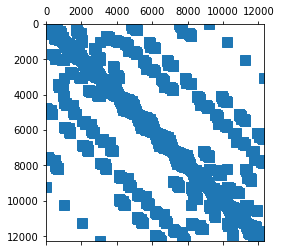

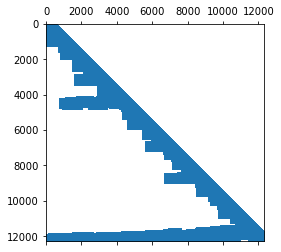

In [4]:
plt.spy(A)
plt.show()
plt.spy(factor.L())

In [5]:
#scipy.sparse.save_npz('matrices/{}_cholB'.format(nside), factor.L())

### 1.2) Measuring the time to solve the two sparse triangular systems

In [6]:
b = np.ones(npix)
t = time()
x0 = factor.solve_A(A@b)
print(time()-t)

0.005061149597167969


# 2) Naive solution of the system

In [7]:
B_array = B.toarray()
A_array = A.toarray()
t = time()
x1 = np.linalg.solve(B_array,A_array@b)
naive_time = time()-t
print(naive_time)

47.731324911117554


The solutions obtained with the two methods are actually almost the same:

In [8]:
np.linalg.norm(x0-x1)

7.182142331109502e-11

# 3) Tensorflow implementation (full Cholesky decomposition)

In [9]:
import tensorflow as tf;

/Users/Mart/anaconda3/envs/scikits-sparse/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Mart/anaconda3/envs/scikits-sparse/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Mart/anaconda3/envs/scikits-sparse/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Mart/anaconda3/env

In [13]:
RHS = np.random.rand(npix,1) 
t = time()
chol = tf.cholesky(A_array)  # shape 10 x 2 x 2
print(time()-t)

20.306830167770386


In [14]:
chol

<tf.Tensor 'Cholesky_1:0' shape=(12288, 12288) dtype=float64>

In [15]:
t = time()
X = tf.cholesky_solve(chol, RHS)
print(time()-t)
# tf.matmul(A, X) ~ RHS
X  # Solution to the linear system A x = RHS

0.017293214797973633


<tf.Tensor 'cholesky_solve_4/MatrixTriangularSolve_1:0' shape=(12288, 1) dtype=float64>

In [ ]:
naive_line = []
tf_line = []
nsides = [4,8,16, 32]

for nside in nsides:
    A = scipy.sparse.load_npz('matrices/{}_stiffness.npz'.format(nside))
    B = scipy.sparse.load_npz('matrices/{}_mass.npz'.format(nside))
    cholB = scipy.sparse.load_npz('matrices/{}_cholB.npz'.format(nside))
    npix = A.shape[0]
    
    # naive solve
    b = np.ones(npix)
    B_array = B.toarray()
    A_array = A.toarray()
    RHS = A_array@b
    t = time()
    x1 = np.linalg.solve(B_array,RHS)
    naive_time = time()-t
    naive_line.append(naive_time)
    print("nside = {}, naive time = {}".format(nside, naive_time))
    
    # tensorflow cholesky_solve
    
    # WARNING: IT IS FUNDAMENTAL TO USE TF.TENSORS in tf.cholesky_solve, otherwise it takes ages    
    cholB_tensor = tf.constant(cholB.toarray())
    RHS = np.random.rand(npix,1)
    t = time()
    X = tf.cholesky_solve(cholB_tensor, RHS)
    tf_time = time()-t
    tf_line.append(tf_time)
    print("nside = {}, cholesky time = {}".format(nside, tf_time))


plt.plot(naive_line, 'b')
plt.plot(tf_line, 'g')
plt.yscale('log')
plt.show()

nside = 4, naive time = 0.003130197525024414
nside = 4, cholesky time = 0.004248142242431641
nside = 8, naive time = 0.027750253677368164
nside = 8, cholesky time = 0.0043849945068359375
nside = 16, naive time = 0.9594411849975586
nside = 16, cholesky time = 0.002524137496948242
nside = 32, naive time = 49.80830216407776
nside = 32, cholesky time = 0.04708099365234375
